# Setup

## Install Conda (Optional)

In [ ]:
!wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh

!chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh

!bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local 
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

## Install python==3.8 (Optional)

In [ ]:
!conda install python=3.8

In [1]:
!python --version

Python 3.7.12


## Install dependencies

In [ ]:
!pip install opencv-python
!pip install pycocotools
!pip install ipykernel
!pip install scipy
!pip install torch==1.6.0 torchvision==0.7.0
!pip install open3d

## Clone M3D-VTON repo

In [3]:
!git clone https://github.com/fyviezhao/m3d-vton

Cloning into 'm3d-vton'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 109 (delta 24), reused 100 (delta 20), pack-reused 0
Receiving objects: 100% (109/109), 3.75 MiB | 13.23 MiB/s, done.
Resolving deltas: 100% (24/24), done.


## Download Pretrained Models

In [1]:
cd m3d-vton/pretrained

/content/m3d-vton/pretrained


In [5]:
!gdown https://drive.google.com/uc?id=1wpN-yfa1_MbezqkcLfVspa2jVTJV7bjN

Downloading...
From: https://drive.google.com/uc?id=1wpN-yfa1_MbezqkcLfVspa2jVTJV7bjN
To: /content/m3d-vton/pretrained/M3D-VTON.zip
100% 513M/513M [00:02<00:00, 214MB/s]


In [6]:
!unzip M3D-VTON.zip 

Archive:  M3D-VTON.zip
 extracting: latest_net_TFM.pth      
 extracting: latest_net_MTM.pth      
 extracting: latest_net_DRM.pth      
replace readme.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: readme.txt              


In [7]:
!mv latest_net_DRM.pth ./aligned/DRM/
!mv latest_net_MTM.pth ./aligned/MTM/
!mv latest_net_TFM.pth ./aligned/TFM/

In [2]:
cd ..

/content/m3d-vton


In [ ]:
# import cv2
# import matplotlib.pyplot as plt
# from google.colab.patches import cv2_imshow

# img = cv2.imread('/content/m3d-vton/mpv3d_example/cloth-mask/s.jpg')
# img= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
# ret, thresh = cv2.threshold(img,200, 255, cv2.THRESH_BINARY_INV)
# cv2_imshow(thresh)
# cv2.imwrite('/content/m3d-vton/mpv3d_example/cloth-mask/s_mask.jpg', thresh)

# Input Setup

## Follow the following steps:

### Custom Data

If you want to process your own data, some more steps are needed (the &#8594; indicates the corresponding folder where the images should be put into):

1. prepare an in-shop clothing image *C* (&#8594; `input_data/cloth`) and a frontal person image *P* (&#8594; `input_data/image`) with resolution of 320*512;

2. obtain the mask of *C* (&#8594; `input_data/cloth-mask`) by thresholding or using [remove.bg](https://www.remove.bg/);

3. obtain the human segmentation layout (&#8594; `input_data/image-parse`) by applying [2D-Human-Paring](https://github.com/fyviezhao/2D-Human-Parsing) on *P*;

4. obtain the human joints (&#8594; `input_data/pose`) by applying [OpenPose](https://github.com/CMU-Perceptual-Computing-Lab/openpose) (25 keypoints) on *P*;

5. run the data processing script `python util/data_preprocessing.py --MPV3D_root input_data` to automatically obtain the remaining inputs (pre-aligned clothing, palm mask, and image gradients);

6. now the data preparation is finished and you should be able to run inference with the steps described in the next section "Running Inference". 

## Running Inference
We provide demo inputs under the `input_data` folder, where the target clothing and the reference person are like:

with inputs from the `input_data` folder, the easiest way to get start is to use the [pretrained models](https://figshare.com/s/fad809619d2f9ac666fc) and sequentially run the four steps below:

### 1. Testing MTM Module
```sh
python test.py --model MTM --name MTM --dataroot input_data --datalist test_pairs --results_dir results
```

### 2. Testing DRM Module
```sh
python test.py --model DRM --name DRM --dataroot input_data --datalist test_pairs --results_dir results
```  

### 3. Testing TFM Module
```sh
python test.py --model TFM --name TFM --dataroot input_data --datalist test_pairs --results_dir results
```

### 4. Getting colored point cloud and Remeshing

(Note: since the back-side person images are unavailable, in `rgbd2pcd.py` we provide a fast face inpainting function that produces the mirrored back-side image after a fashion. One may need manually inpaint other back-side texture areas to achieve better visual quality.)

```sh
python rgbd2pcd.py
```

Now you should get the point cloud file prepared for remeshing under `results/aligned/pcd/test_pairs/*.ply`. [MeshLab](https://www.meshlab.net/) can be used to remesh the predicted point cloud, with two simple steps below:

- Normal Estimation: Open MeshLab and load the point cloud file, and then go to Filters --> Normals, Curvatures and Orientation --> Compute normals for point sets

- Possion Remeshing: Go to Filters --> Remeshing, Simplification and Reconstruction --> Surface Reconstruction: Screen Possion (set reconstruction depth = 9)

## Folder Structure

Create a folder called input_data with the following structure:

__input_data__

-->__cloth__

---->cloth@1=cloth_front.jpg

---->cloth@2=cloth_front.jpg

----> ...

-->__cloth-mask__

---->cloth@1=cloth_front_mask.jpg

---->cloth@2=cloth_front_mask.jpg

----> ...

-->__image__

---->person@1=person_whole_front.png

---->person@2=person_whole_front.png

----> ...

-->__image-parse__

---->person@1=person_whole_front_label.png

---->person@2=person_whole_front_label.png

----> ...

-->__pose__

---->person@1=person_whole_front_keypoints.json

---->person@2=person_whole_front_keypoints.json

----> ...

-->test_pairs.txt

-->train_pairs.txt

The test_pairs.txt and train_pairs.txt file will have the following format:

person@1=person_whole_front.png    cloth@1=cloth_front.jpg

person@2=person_whole_front.png    cloth@2=cloth_front.jpg

Each image should have the following proportions:
- width= 320
- height= 512
- bit depth= 24

# Preprocessing Data

Replace line 194 and 233 in data_preprocessing.py with:

sorted([i for \_,_,i in os.walk(person_root)][0])




In [20]:
!python util/data_preprocessing.py --MPV3D_root input_data

1it [00:00, 13.07it/s]
1it [00:00, 17.91it/s]
clothes pre-alignment done and saved to input_data/aligned/test_pairs/cloth!
100% 1/1 [00:00<00:00, 53.72it/s]
palms segmentaion done and saved to input_data/palm-mask!
100% 1/1 [00:00<00:00, 11.19it/s]
Getting image sobel done and saving to input_data/image-sobel!
******Data preprocessing done!******


# Taking Infrence using models

In [21]:
!python test.py --model MTM --name MTM --dataroot input_data --datalist test_pairs --results_dir results

----------------- Options ---------------
                add_depth: True                          
            add_grid_loss: False                         
                add_segmt: True                          
           add_theta_loss: False                         
                  add_tps: True                          
             aspect_ratio: 1.0                           
               batch_size: 8                             
          checkpoints_dir: pretrained                    
                 datalist: test_pairs                    
                 datamode: aligned                       
                 dataroot: input_data                    	[default: mpv3d_example]
          display_winsize: 512                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                grid_size: 3                             
     

In [22]:
!python test.py --model DRM --name DRM --dataroot input_data --datalist test_pairs --results_dir results

----------------- Options ---------------
             add_gan_loss: False                         
            add_grad_loss: True                          
          add_normal_loss: False                         
             aspect_ratio: 1.0                           
               batch_size: 8                             
          checkpoints_dir: pretrained                    
                 datalist: test_pairs                    
                 datamode: aligned                       
                 dataroot: input_data                    	[default: mpv3d_example]
            display_ncols: 2                             
          display_winsize: 512                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
               img_height: 512                           
                img_width: 320                           
     

In [23]:
!python test.py --model TFM --name TFM --dataroot input_data --datalist test_pairs --results_dir results

----------------- Options ---------------
             add_gan_loss: False                         
             aspect_ratio: 1.0                           
               batch_size: 8                             
          checkpoints_dir: pretrained                    
                 datalist: test_pairs                    
                 datamode: aligned                       
                 dataroot: input_data                    	[default: mpv3d_example]
          display_winsize: 512                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
               img_height: 512                           
                img_width: 320                           
                init_gain: 0.02                          
                init_type: normal                        
              input_depth: True                          
     

In [25]:
!python rgbd2pcd.py --parse_root input_data/image-parse

100% 2/2 [00:00<00:00,  4.69it/s]
The unprojected point cloud file(s) are saved to results/aligned/pcd/test_pairs


# Post processing point cloud

In [7]:
!mkdir ./results/aligned/final_pcd

In [8]:
# post processing point cloud

import open3d as o3d 

# load point cloud
pcd = o3d.io.read_point_cloud('./results/aligned/pcd/test_pairs/person@1=person.ply')

# normal estimation
pcd.estimate_normals()
pcd.orient_normals_consistent_tangent_plane(100)

# poisson surface reconstruction
mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=9)

# save mesh
o3d.io.write_triangle_mesh('./results/aligned/final_pcd/person@1=person.ply', mesh)

True

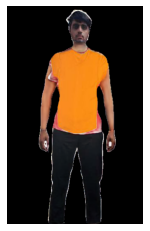

In [10]:
# display 2D result

import cv2
import matplotlib.pyplot as plt

img_path = './results/aligned/TFM/test_pairs/tryon/person@1=person_whole_front.png'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


plt.imshow(img)
plt.axis('off')
plt.show()